In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,20)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE


In [33]:
#upload data
df = pd.read_excel('data/REdata.xlsx')


In [34]:
#check data
df.shape

(993, 4)

In [35]:
df.isnull().sum()

Subtitle values    0
Price, EUR         0
Number of rooms    0
Size (m²)          0
dtype: int64

In [36]:
df.describe()

,"Price, EUR",Number of rooms,Size (m²)
count,993.000000,993.000000,993.000000
mean,139931.326284,2.419436,60.692568
std,79476.207939,1.100566,30.598882
min,25850.000000,0.500000,16.000000
25%,89600.000000,1.500000,40.000000
50%,121200.000000,2.500000,55.000000
75%,168000.000000,3.000000,72.000000
max,754490.000000,5.000000,274.000000


In [37]:
df['Price per m², EUR'] = df['Price, EUR']/df['Size (m²)']
df['Price per m², EUR'] = df['Price per m², EUR'].round(2)

In [38]:
df.describe()

,"Price, EUR",Number of rooms,Size (m²),"Price per m², EUR"
count,993.000000,993.000000,993.000000,993.000000
mean,139931.326284,2.419436,60.692568,2346.486616
std,79476.207939,1.100566,30.598882,535.930406
min,25850.000000,0.500000,16.000000,972.970000
25%,89600.000000,1.500000,40.000000,1952.630000
50%,121200.000000,2.500000,55.000000,2350.730000
75%,168000.000000,3.000000,72.000000,2641.940000
max,754490.000000,5.000000,274.000000,4929.580000


In [39]:

# Function to detect outliers using z-score
numerical_columns = ['Price, EUR', 'Number of rooms', 'Size (m²)', 'Price per m², EUR']


def detect_outliers_z_score(data: pd.DataFrame, threshold=3):
    outliers = []
    for col in data.columns:
        if col in numerical_columns:
            z_scores = (data[col] - data[col].mean()) / data[col].std()
            outlier_indices = np.abs(z_scores) > threshold
            outliers.extend(data.index[outlier_indices].tolist())
    return list(set(outliers))

# Function to remove outliers from DataFrame
def remove_outliers(data, outliers):
    cleaned_data = data.drop(outliers)
    return cleaned_data

# Detect outliers in the DataFrame
outliers = detect_outliers_z_score(df)

if outliers:
    df = remove_outliers(df,outliers)
    print(f'{len(outliers)} outliers were detected. Outliers have been removed')
else:
    print('No outliers have been detected')



23 outliers were detected. Outliers have been removed


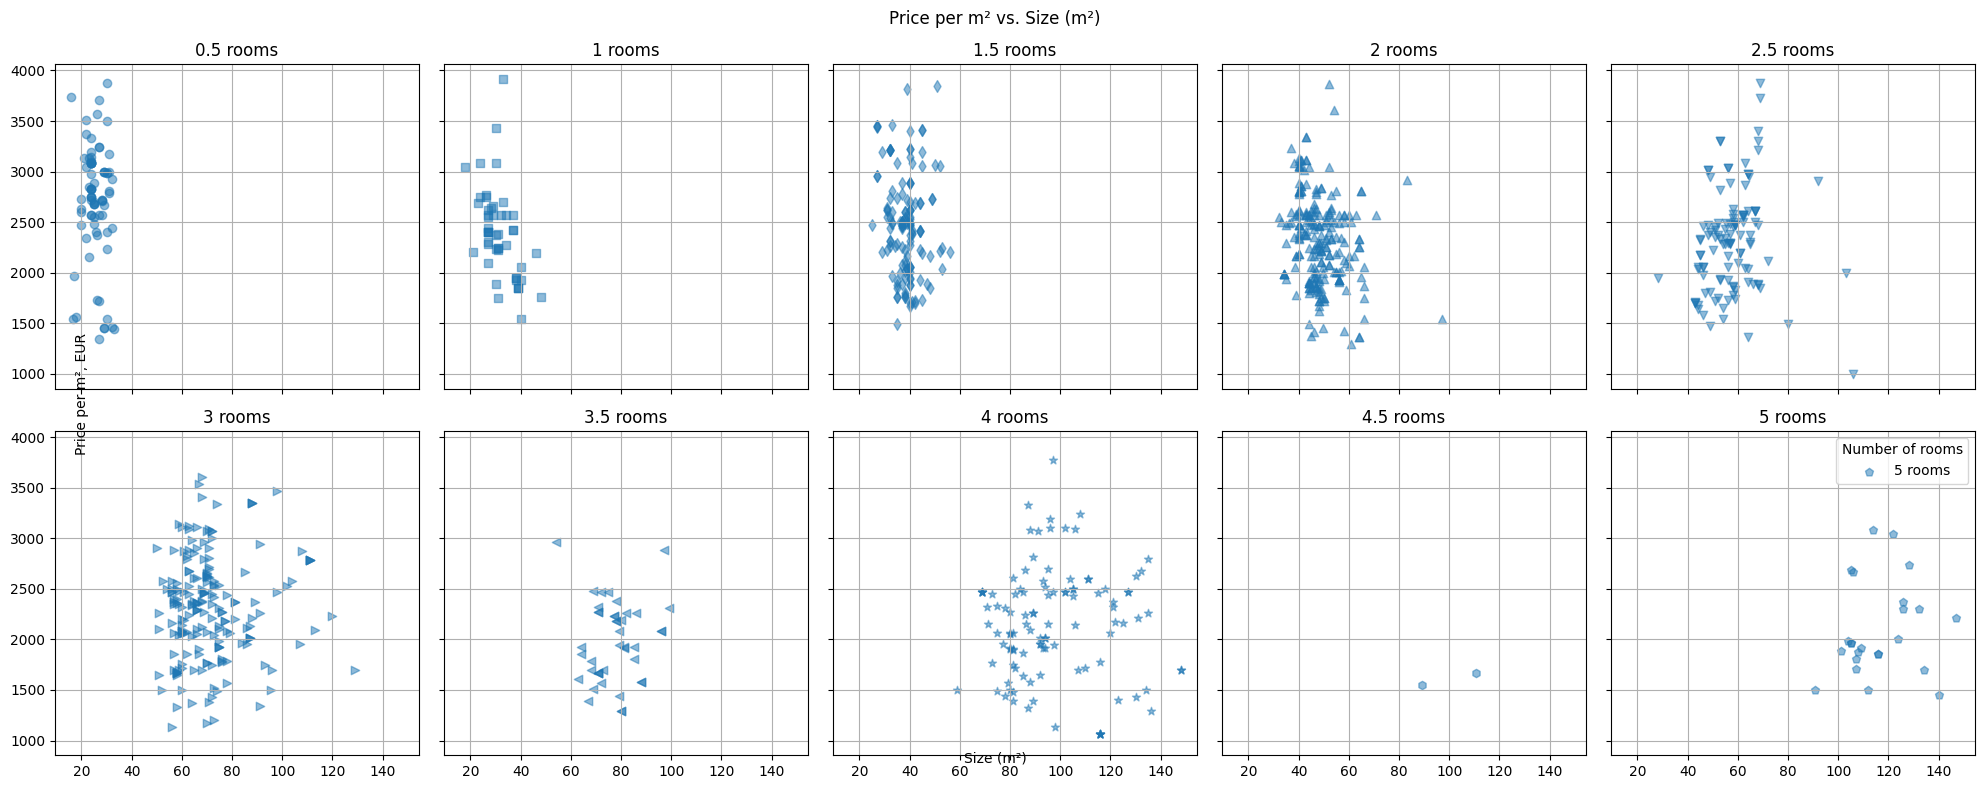

In [40]:
 # Create a scatter plot

marker_styles = {0.5: 'o', 1: 's', 1.5: 'd', 2: '^', 2.5: 'v', 3: '>', 3.5: '<', 4: '*', 4.5: 'h', 5: 'p'}

fig, axs = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)

for i, room_num in enumerate([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]):
    room_df = df[df['Number of rooms'] == room_num]
    ax = axs.flat[i]
    ax.scatter(room_df['Size (m²)'], room_df['Price per m², EUR'], label=f'{room_num} rooms',
                marker=marker_styles[room_num], alpha=0.5)
    ax.set_title(f'{room_num} rooms')
fig.suptitle('Price per m² vs. Size (m²)')
fig.text(0.5, 0.04, 'Size (m²)', ha='center')
fig.text(0.04, 0.5, 'Price per m², EUR', va='center', rotation='vertical')
axs.flat[-1].legend(title='Number of rooms')
for ax in axs.flat:
    ax.grid(True)
plt.tight_layout()
plt.show()


In [41]:
df['Subtitle values'] = df['Subtitle values'].str.lower()  # Convert to lowercase
df['Subtitle values'] = df['Subtitle values'].str.replace(r'[^\w\s]', '')  # Remove punctuation

# Tokenization and splitting
df['District'] = df['Subtitle values'].str.split(',').str[0].str.strip()  # Extract district
df['Street'] = df['Subtitle values'].str.split(',').str[1].str.strip()  #



In [42]:
df.drop('Subtitle values', axis=1, inplace=True)
df.drop('Street' , axis='columns',inplace=True)

In [43]:
district_stats = df.groupby('District')['Price, EUR'].agg(['count','mean', 'min', 'max', 'std'])

# Rename the columns for clarity
district_stats.columns = ['Count', 'Mean Price', 'Min Price', 'Max Price', 'Price Std']

# Reset index to make 'District' a regular column
district_stats.reset_index(inplace=True)

district_stats.round(2)


,District,Count,Mean Price,Min Price,Max Price,Price Std
0,adamovićevo naselje,4,119480.00,95270,141410,20376.60
1,adice,73,88988.07,25850,141850,27473.21
2,avijatičarsko naselje,8,73900.00,67700,89000,8949.54
3,banatić,2,73635.00,65900,81370,10938.94
4,betanija,3,106483.33,97850,123600,14823.66
5,bistrica,12,135725.83,74150,199820,49160.76
6,bulevar evrope,16,158877.50,83430,288400,64682.85
7,bulevar oslobođenja,39,172660.00,46350,350800,77128.86
8,bulevar patrijarha pavla,23,132541.30,74160,366000,63022.75
9,cara dušana,5,189994.00,145000,257500,57926.01


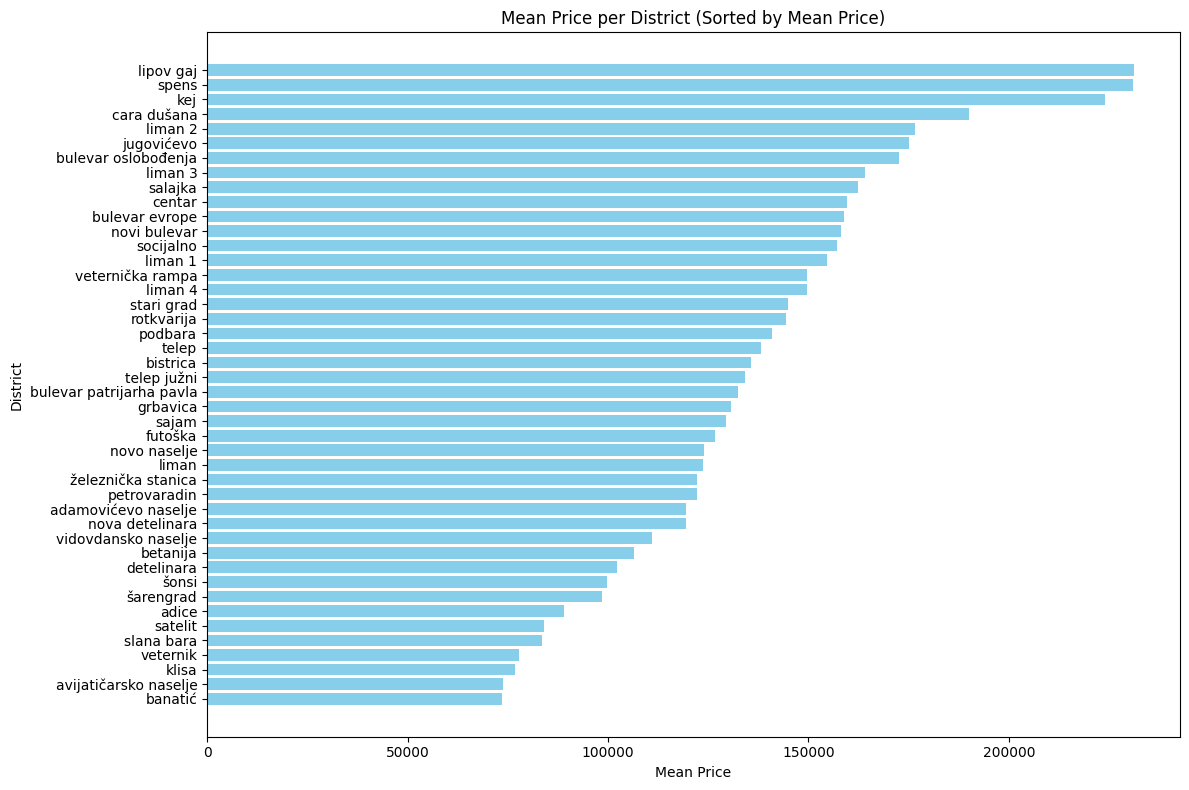

In [44]:
# Sort districts by mean price
district_stats_sorted = district_stats.sort_values(by='Mean Price')

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting mean price per district
ax.barh(district_stats_sorted['District'], district_stats_sorted['Mean Price'], color='skyblue')

# Setting labels and title
ax.set_xlabel('Mean Price')
ax.set_ylabel('District')
ax.set_title('Mean Price per District (Sorted by Mean Price)')

# Show plot
plt.tight_layout()
plt.show()

In [45]:
# Encoding categorical variables
district_dummies = pd.get_dummies(df['District'])


In [46]:
# Concatenate the dummy variables with the original DataFrame
df_encoded = pd.concat([df, district_dummies], axis=1)

In [47]:
df_encoded.drop('District' , axis='columns',inplace=True)

In [48]:
X_data = df_encoded.drop(['Price, EUR', 'Price per m², EUR'], axis=1)
y_data = df_encoded['Price, EUR']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.35, random_state=10)

In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8045319222873121

In [51]:
def predict_price(model, district, num_rooms, size_sqm):

    # Preprocess district name
    district = district.lower().strip()
    
    # Create a DataFrame with the encoded district
    district_df = pd.DataFrame(columns=district_dummies.columns)
    district_df.loc[0] = 0  # Initialize all district dummy columns to zero
    if district in district_df.columns:
        district_df[district] = 1  # Set the corresponding district dummy to one
    
    # Make prediction
    input_data = pd.DataFrame({
        'Number of rooms': [num_rooms],
        'Size (m²)': [size_sqm]
    })
    input_data = pd.concat([input_data, district_df], axis=1)
    predicted_price = model.predict(input_data)
    
    return predicted_price[0]

# Example usage:
district_name = 'liman 1'  # Example district name
num_rooms = 1.5  # Example number of rooms
size_sqm = 40.0  # Example size in square meters

predicted_price = predict_price(lr_model, district_name, num_rooms, size_sqm)
print(f"Predicted price for a property with {num_rooms} rooms, size {size_sqm} m² in {district_name.capitalize()}: {predicted_price:.2f} EUR")


Predicted price for a property with 1.5 rooms, size 40.0 m² in Liman 1: 106931.50 EUR
